<a href="https://colab.research.google.com/github/HimalKarkal/netball-analysis/blob/master/TrueSkill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Required Packages

In [ ]:
# GitHub repository
!git clone https://github.com/HimalKarkal/netball-analysis.git

# TrueSkill
!pip install trueskill

import pandas as pd
import numpy as np
from trueskill import Rating, rate

Cloning into 'netball-analysis'...
remote: Enumerating objects: 26823, done.
remote: Counting objects: 100% (3051/3051), done.
remote: Compressing objects: 100% (2519/2519), done.
remote: Total 26823 (delta 691), reused 2786 (delta 433), pack-reused 23772
Receiving objects: 100% (26823/26823), 44.06 MiB | 12.19 MiB/s, done.
Resolving deltas: 100% (12878/12878), done.
Updating files: 100% (14885/14885), done.
  Preparing metadata (setup.py) ... done
  Created wheel for trueskill: filename=trueskill-0.4.5-py3-none-any.whl size=18049 sha256=738cd71f09ff3d078485ec09012a99aece71ea647cc08fb050cebd74d501cc28
  Stored in directory: /root/.cache/pip/wheels/b9/4f/29/c79f0a2956775524c7a23638ac2b6fbb516c680f8e5eed9b53
Successfully built trueskill


# Trueskill applied to Match Outcome

In [ ]:
import glob

minutesPlayed = glob.glob('/content/netball-analysis/data/matchCentre/processed/*/*minutesPlayed_202*_SSN_*.csv')
minutesPlayed = sorted(minutesPlayed)

teamStats = glob.glob('/content/netball-analysis/data/matchCentre/processed/*/*teamStats_202*_SSN_*.csv')
teamStats = sorted(teamStats)


In [ ]:
# Rating players from 2020 to 2023

player_ratings = {}

for i in range(len(minutesPlayed)):
  df_minutesPlayed = pd.read_csv(minutesPlayed[i])
  df_teamStats = pd.read_csv(teamStats[i])
  df_teamStats = df_teamStats[['squadId','points']]
  df_merged = pd.merge(left = df_minutesPlayed, right = df_teamStats, how = 'left',  left_on = 'squadId', right_on = 'squadId')

  for j in df_merged.index:
    if df_merged['playerId'][j] not in player_ratings:
      player_ratings[df_merged['playerId'][j]] = Rating(mu = 1000, sigma = 333.333)

  df_merged['weight'] = (df_merged['minutesPlayed'] / 60).round(2) # Weights for minutes played
  squads = df_merged['squadId'].unique().tolist() # List of squadIds

  # List of playerIds in team_1
  playerIds_team_1 = (df_merged[df_merged['squadId'] == squads[0]]['playerId'].tolist())

  # List of playerIds in team_2
  playerIds_team_2 = (df_merged[df_merged['squadId'] == squads[1]]['playerId'].tolist())

  ratings_team_1 = []
  for key in playerIds_team_1:
    ratings_team_1.append(player_ratings[key])
  ratings_team_1 = tuple(ratings_team_1)

  ratings_team_2 = []
  for key in playerIds_team_2:
    ratings_team_2.append(player_ratings[key])
  ratings_team_2 = tuple(ratings_team_2)

  weights_team_1 = tuple(df_merged[df_merged['squadId'] == squads[0]]['weight'].tolist()) # Tuple of weights team_1
  weights_team_2 = tuple(df_merged[df_merged['squadId'] == squads[1]]['weight'].tolist()) # Tuple of weights team_2

  # Ranks team_1 vs team_2
  if df_teamStats[df_teamStats['squadId'] == squads[0]]['points'].values > df_teamStats[df_teamStats['squadId'] == squads[1]]['points'].values:
    ranks = [0,1]
  elif df_teamStats[df_teamStats['squadId'] == squads[0]]['points'].values == df_teamStats[df_teamStats['squadId'] == squads[1]]['points'].values:
    ranks = [0,0]
  else:
    ranks = [1,0]

  # Update ratings game
  ratings_team_1, ratings_team_2 = rate(rating_groups = [ratings_team_1,ratings_team_2], ranks = ranks, weights = [weights_team_1, weights_team_2] )

  #Update dictionary for team_1
  for i, key in enumerate(playerIds_team_1):
    if key in player_ratings:
      player_ratings[key] = ratings_team_1[i]
    else:
      print(f"Key '{key}' not found in the dictionary")

  #Update dictionary for team_2
  for i, key in enumerate(playerIds_team_2):
    if key in player_ratings:
      player_ratings[key] = ratings_team_2[i]
    else:
      print(f"Key '{key}' not found in the dictionary")

player_ratings

{80078: trueskill.Rating(mu=1150.532, sigma=146.520),
 1007306: trueskill.Rating(mu=1079.359, sigma=163.294),
 1004472: trueskill.Rating(mu=1036.254, sigma=159.848),
 1000831: trueskill.Rating(mu=1206.133, sigma=129.857),
 991905: trueskill.Rating(mu=948.796, sigma=145.576),
 1007219: trueskill.Rating(mu=919.100, sigma=174.489),
 1006231: trueskill.Rating(mu=1137.506, sigma=167.034),
 1005495: trueskill.Rating(mu=562.855, sigma=269.103),
 1015274: trueskill.Rating(mu=1034.987, sigma=273.498),
 1021092: trueskill.Rating(mu=985.436, sigma=280.550),
 1009721: trueskill.Rating(mu=994.470, sigma=331.148),
 1019380: trueskill.Rating(mu=1038.434, sigma=313.411),
 1001357: trueskill.Rating(mu=1084.904, sigma=132.539),
 80475: trueskill.Rating(mu=1022.940, sigma=132.936),
 80296: trueskill.Rating(mu=973.728, sigma=128.455),
 80105: trueskill.Rating(mu=976.227, sigma=235.440),
 998401: trueskill.Rating(mu=884.663, sigma=213.540),
 80559: trueskill.Rating(mu=1039.535, sigma=141.736),
 999135: tru

In [ ]:
max_key = max(player_ratings, key=player_ratings.get)  # Key with max value

# Get the corresponding value using the key
max_value = player_ratings[max_key]

print(f"Best player ID: {max_key}")
print(f"Player Rating: {max_value}")

Best player ID: 994224
Player Rating: trueskill.Rating(mu=1405.596, sigma=125.413)


In [ ]:
final_ratings = pd.DataFrame(player_ratings.items(), columns=['playerId', 'rating'])
final_ratings['mu'] = final_ratings['rating'].apply(lambda x: x.mu)
final_ratings['sigma'] = final_ratings['rating'].apply(lambda x: x.sigma)
final_ratings

,playerId,rating,mu,sigma
0,80078,"trueskill.Rating(mu=1150.532, sigma=146.520)",1150.532443,146.519885
1,1007306,"trueskill.Rating(mu=1079.359, sigma=163.294)",1079.358950,163.293685
2,1004472,"trueskill.Rating(mu=1036.254, sigma=159.848)",1036.253957,159.848062
3,1000831,"trueskill.Rating(mu=1206.133, sigma=129.857)",1206.132604,129.856664
4,991905,"trueskill.Rating(mu=948.796, sigma=145.576)",948.795837,145.575734
...,...,...,...,...
156,1019170,"trueskill.Rating(mu=725.886, sigma=316.295)",725.886051,316.294941
157,80009,"trueskill.Rating(mu=935.342, sigma=325.186)",935.342065,325.186101
158,1029529,"trueskill.Rating(mu=842.589, sigma=330.399)",842.588740,330.398813
159,1029514,"trueskill.Rating(mu=1212.379, sigma=272.764)",1212.378898,272.764116


In [ ]:
top_10 = final_ratings.nlargest(10, 'mu')
top_10

,playerId,rating,mu,sigma
74,994224,"trueskill.Rating(mu=1405.596, sigma=125.413)",1405.596153,125.413107
111,80299,"trueskill.Rating(mu=1377.867, sigma=134.794)",1377.867101,134.793980
148,1006558,"trueskill.Rating(mu=1309.216, sigma=163.625)",1309.215710,163.624927
150,1029501,"trueskill.Rating(mu=1220.819, sigma=230.475)",1220.819084,230.475036
115,1019205,"trueskill.Rating(mu=1212.663, sigma=142.514)",1212.662602,142.513684
159,1029514,"trueskill.Rating(mu=1212.379, sigma=272.764)",1212.378898,272.764116
153,1028098,"trueskill.Rating(mu=1210.598, sigma=252.242)",1210.597517,252.241787
3,1000831,"trueskill.Rating(mu=1206.133, sigma=129.857)",1206.132604,129.856664
149,1029513,"trueskill.Rating(mu=1197.760, sigma=204.831)",1197.759507,204.830639
147,1025020,"trueskill.Rating(mu=1194.738, sigma=283.881)",1194.738022,283.881395


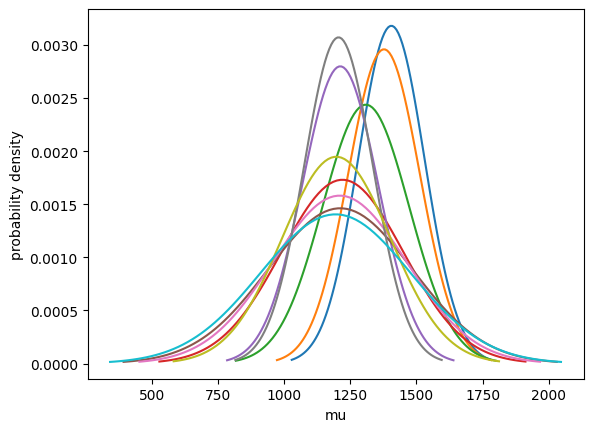

In [ ]:

import scipy
import numpy as np
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots()

# Loop through each row of final_ratings
for i, row in top_10.iterrows():
  # Get the mu and sigma values
  mu = row['mu']
  sigma = row['sigma']

  # Create a normal distribution curve
  x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
  y = scipy.stats.norm.pdf(x, mu, sigma)

  # Plot the curve
  ax.plot(x, y, label=f'Player {row["playerId"]}')

# Add a legend and show the plot
plt.xlabel('mu')
plt.ylabel('probability density')
plt.show()


# Estimating home advantage

In [ ]:
df_final = pd.DataFrame()

import glob
paths_mi = glob.glob('/content/netball-analysis/data/matchCentre/processed/*/*_matchInfo_202[0,1,2,3]_SSN_*.json')
paths_ts = glob.glob('/content/netball-analysis/data/matchCentre/processed/*/*_teamStats_202[0,1,2,3]_SSN_*.csv')

for i in range(0,240):
  df_mi = pd.read_json(paths_mi[i])
  df_mi = df_mi[['homeSquadId', 'awaySquadId']]
  df_score = pd.read_csv(paths_ts[i])
  df_score = df_score[['squadId', 'points']]

  # Applying logic

  if df_mi['homeSquadId'].iloc[0] == df_score['squadId'].iloc[0]:
    home_score = df_score['points'][0]
    away_score = df_score['points'][1]
  else:
    home_score = df_score['points'][1]
    away_score = df_score['points'][0]

  # Creating results


  df_final = pd.concat([df_final, pd.DataFrame({'Home': [home_score], 'Away': [away_score]})], ignore_index=True)

df_final['Win'] = np.where(df_final['Home'] > df_final['Away'], 1, 0)

df_final.head()

,Home,Away,Win
0,64.0,60.0,1
1,86.0,77.0,1
2,75.0,68.0,1
3,54.0,68.0,0
4,72.0,61.0,1


In [ ]:
# Counting the number of 1s and 0s in df_final

df_final['Win'].value_counts()


In [ ]:
1476/(1476+1404)

0.5125

# TrueSkill Applied to Individual Statistics

The idea now is to apply TrueSkill to individual statistics for each player. I will start with Goals Scored. I create a dictionary that will store the number of goals scored by each player in the league for 5 most recent games that they play in. A rolling average will be used to create the 'expected goals' for each player. The number of goals scored by the player in the next game will be compared against this number in the TrueSkill function.

Defenders and Midfielders who cannot score goals will not be impacted by this because their rolling average will likely be 0 and the goals scored in the next game will also likely be 0. A draw in TrueSkill only adjusts the sigma value which will reduce. This will increase our certainty that this player scores no goals in a match.

**Logic list**

1. Create a goals dictionary.

2.

3. Write a logic to keep appending goals to the dictionary list till len(list)==5. Once this is True, average the numbers and input to TrueSkill, pop the first value in list and add the current value.

4.





In [ ]:
# Getting Data
# This block uses the glob function to create a list the paths for the minutesPlayed and playerStats files.
# It then sorts items in both lists to ensure that the nth item in each list corresponds to the same game.

import glob
import pandas as pd
import numpy as np

paths_minutesPlayed = glob.glob('/content/netball-analysis/data/matchCentre/processed/*/*minutesPlayed_202*_SSN_*.csv')
paths_minutesPlayed = sorted(paths_minutesPlayed)

paths_playerStats = glob.glob('/content/netball-analysis/data/matchCentre/processed/*/*playerStats_202*_SSN_*.csv')
paths_playerStats = sorted(paths_playerStats)

In [ ]:
from trueskill import rate_1vs1, Rating

#SECTION 1
# Creating empty Goals and Goals Rating Dictionaries.

dict_goals = {}
dict_goals_rating = {}
dict_rolling_goals_rating = {}

#SECTION 2
# Setting up the for loop to run on all matches.

for i in range(len(paths_minutesPlayed)):

  #SECTION 3
  #Reading in and merging minutesPlayed and playerStats dataframes.

  df_minutesPlayed = pd.read_csv(paths_minutesPlayed[i]) # change 0 in brackets to i once you set up a for loop
  df_playerStats = pd.read_csv(paths_playerStats[i]) # change 0 in brackets to i once you set up a for loop
  df_merged = pd.merge(left = df_minutesPlayed, right = df_playerStats[['playerId','goals']], how = 'left')

  for j in df_merged.index:
    if df_merged['playerId'][j] not in dict_goals_rating:
      dict_goals_rating[df_merged['playerId'][j]] = Rating(mu = 1000, sigma = 333.333)

  for j in df_merged.index:
    if df_merged['playerId'][j] not in dict_rolling_goals_rating:
      dict_rolling_goals_rating[df_merged['playerId'][j]] = Rating(mu = 1000, sigma = 333.333)

  #df_merged.head()

  # SECTION 4
  # This section looks at each row in df_merged and checks whether the dict_goals has a key with that row's playerId.
  # If NO: Creates a new key and feeds it the corresponding goals as value.
  # If YES and less than 5 items in value list: Calculates mean of present list, then adds the new goal number to list.
  # If YES and more than 5 items in value list: Calculates mean for the present list, then pops first value and appends new goal number to list.
  # The mean is then appended to the rolling average list. This will subsequently be presented to TrueSkill.


  for i, row in df_merged.iterrows():
    player_rating = dict_goals_rating[row['playerId']]
    rolling_average_rating = dict_rolling_goals_rating[row['playerId']]
    goals = row['goals']

    if row['playerId'] not in dict_goals:
      rolling_average = 0
      dict_goals[row['playerId']] = [row['goals']]

    elif len(dict_goals[row['playerId']]) < 5:
      rolling_average = np.mean(dict_goals[row['playerId']])
      dict_goals[row['playerId']].append(row['goals'])

    else:
      rolling_average = np.mean(dict_goals[row['playerId']])

      if goals > rolling_average:
        player_rating, rolling_average_rating = rate_1vs1(player_rating, rolling_average_rating)
      elif goals < rolling_average:
        rolling_average_rating, player_rating = rate_1vs1(rolling_average_rating, player_rating)
      else:
        player_rating, rolling_average_rating = rate_1vs1(player_rating, rolling_average_rating, drawn = True)

      dict_goals_rating[row['playerId']] = player_rating
      dict_rolling_goals_rating[row['playerId']] = rolling_average_rating

      dict_goals[row['playerId']].pop(0)
      dict_goals[row['playerId']].append(row['goals'])

print('Goals Ratings: ', dict_goals_rating)
print('Rolling average ratings: ',dict_rolling_goals_rating)


Goals Ratings:  {80078: trueskill.Rating(mu=995.993, sigma=2.789), 1007306: trueskill.Rating(mu=1000.172, sigma=1.693), 1004472: trueskill.Rating(mu=1000.000, sigma=1.030), 1000831: trueskill.Rating(mu=1000.000, sigma=1.018), 991905: trueskill.Rating(mu=1000.000, sigma=1.055), 1007219: trueskill.Rating(mu=1000.000, sigma=1.007), 1006231: trueskill.Rating(mu=1000.000, sigma=1.395), 1005495: trueskill.Rating(mu=1000.000, sigma=1.018), 1015274: trueskill.Rating(mu=1000.000, sigma=2.331), 1021092: trueskill.Rating(mu=999.500, sigma=1.832), 1009721: trueskill.Rating(mu=854.527, sigma=103.850), 1019380: trueskill.Rating(mu=1000.000, sigma=333.333), 1001357: trueskill.Rating(mu=999.324, sigma=1.500), 80475: trueskill.Rating(mu=999.596, sigma=1.486), 80296: trueskill.Rating(mu=1000.000, sigma=1.007), 80105: trueskill.Rating(mu=1000.000, sigma=8.380), 998401: trueskill.Rating(mu=1000.000, sigma=1.728), 80559: trueskill.Rating(mu=1000.000, sigma=1.206), 999135: trueskill.Rating(mu=1000.000, sigm

In [ ]:
# Find the largest key-value pairs in Goals Ratings

max_key = max(dict_goals_rating, key=dict_goals_rating.get)  # Key with max value

# Get the corresponding value using the key
max_value = dict_goals_rating[max_key]

print(f"Best player ID: {max_key}")
print(f"Player Rating: {max_value}")


Best player ID: 1006558
Player Rating: trueskill.Rating(mu=1031.062, sigma=55.821)


In [ ]:
# Creating a dictionary of player list

paths = glob.glob('/content/netball-analysis/data/matchCentre/processed/*/*playerList_202*_SSN_*.csv')

player_list_dict = {}

for i in paths:
  df = pd.read_csv(i)

  for i, row in df.iterrows():
    if row['playerId'] not in player_list_dict:
      player_list_dict[row['playerId']] = row['displayName']


In [ ]:
player_list_dict[1006558]

'E.Cardwell'